<a href="https://colab.research.google.com/github/mvgmarian/matematicas-ml/blob/master/notebooks/regression-in-pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regresión en PyTorch

En este cuaderno, usamos la librería PyTorch **diferenciación automática** para ajustar una recta a puntos de datos. Así, aquí usamos el cálculo para resolver el mismo problema de regresión que usamos para resolver la Pseudoinversa de Moore-Penrose en el [*Cuaderno de Álgebra Lineal II*](https://github.com/joanby/matematicas-ml/blob/master/notebooks/2-linear-algebra-ii.ipynb).

In [ ]:
import torch
import matplotlib.pyplot as plt

In [ ]:
x = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7.]) # P.ej.: Dosis del fármaco para tratar la enfermedad de Alzheimer
x

tensor([0., 1., 2., 3., 4., 5., 6., 7.])

Los valores $y$ se crearon utilizando la ecuación de una recta $y = mx + b$. De este modo, sabemos cuáles son los parámetros del modelo que hay que aprender, digamos, $m = -0,5$ y $b = 2$. Se ha añadido ruido aleatorio distribuido normalmente para simular el error de muestreo:

In [ ]:
# y = -0.5*x + 2 + torch.normal(mean=torch.zeros(8), std=0.2)

Para la reproducibilidad de esta demostración, he aquí un ejemplo fijo de los valores $y$ obtenidos ejecutando la línea comentada anteriormente:

In [ ]:
y = torch.tensor([1.86, 1.31, .62, .33, .09, -.67, -1.23, -1.37]) # Ej: Puntuación de «olvido» del paciente
y

tensor([ 1.8600,  1.3100,  0.6200,  0.3300,  0.0900, -0.6700, -1.2300, -1.3700])

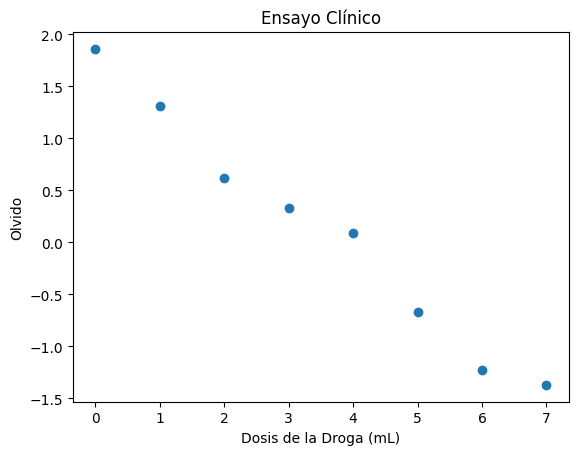

In [ ]:
fig, ax = plt.subplots()
plt.title("Ensayo Clínico")
plt.xlabel("Dosis de la Droga (mL)")
plt.ylabel("Olvido")
_ = ax.scatter(x, y)

Inicializar el parámetro de pendiente $m$ con un valor «aleatorio» de 0,9...

(**N.B.**: En esta sencilla demostración, podríamos empezar adivinando valores de parámetros aproximadamente correctos. O podríamos utilizar un método algebraico (por ejemplo, la pseudoinversa de Moore-Penrose) o estadístico (por ejemplo, la regresión por mínimos cuadrados ordinarios) para resolver los parámetros rápidamente. Sin embargo, esta pequeña demostración de aprendizaje automático con dos parámetros y ocho puntos de datos puede ampliarse a millones de parámetros y millones de puntos de datos. Los demás enfoques -adivinanzas, álgebra, estadística- no se acercan a este escalado).

In [ ]:
m = torch.tensor([0.9]).requires_grad_()
m

tensor([0.9000], requires_grad=True)

...y hacer lo mismo para el parámetro $y$-intercepto $b$:

In [ ]:
b = torch.tensor([0.1]).requires_grad_()
b

tensor([0.1000], requires_grad=True)

In [ ]:
def regression(my_x, my_m, my_b):
    return my_m*my_x + my_b

In [ ]:
def regression_plot(my_x, my_y, my_m, my_b):

    fig, ax = plt.subplots()

    ax.scatter(my_x, my_y)

    x_min, x_max = ax.get_xlim()
    y_min = regression(x_min, my_m, my_b).detach().item()
    y_max = regression(x_max, my_m, my_b).detach().item()

    ax.set_xlim([x_min, x_max])
    _ = ax.plot([x_min, x_max], [y_min, y_max])

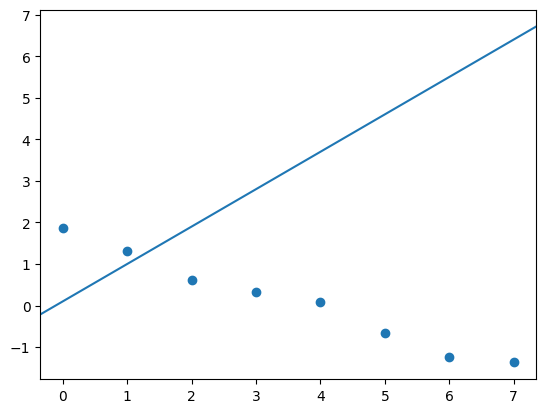

In [ ]:
regression_plot(x, y, m, b)

**Vuelva aquí a las diapositivas si seguimos la clase de *Cálculo I*.**

### Machine Learning
En cuatro pasos muy sencillos :)

**Paso 1**: Paso hacia adelante

In [ ]:
yhat = regression(x, m, b)
yhat

tensor([0.1000, 1.0000, 1.9000, 2.8000, 3.7000, 4.6000, 5.5000, 6.4000],
       grad_fn=<AddBackward0>)

**Paso 2**: Comparar $\hat{y}$ con $y$ verdadero para calcular el coste $C$

Existe un método PyTorch `MSELoss`, pero vamos a definirlo nosotros mismos para ver cómo funciona. El coste MSE se define por: $$C = \frac{1}{n} \sum_{i=1}^n (\hat{y_i}-y_i)^2 $$

In [ ]:
def mse(my_yhat, my_y):
    sigma = torch.sum((my_yhat - my_y)**2)
    return sigma/len(my_y)

In [ ]:
C = mse(yhat, y)
C

tensor(19.6755, grad_fn=<DivBackward0>)

**Paso 3**: Utilizar autodiff para calcular el gradiente de $C$ en función de los parámetros.

In [ ]:
C.backward()

In [ ]:
m.grad

tensor([36.3050])

In [ ]:
b.grad

tensor([6.2650])

**Paso 4**: Gradiente descendente

In [ ]:
optimizer = torch.optim.SGD([m, b], lr=0.01)

In [ ]:
optimizer.step()

Confirme que los parámetros se han ajustado con sensatez:

In [ ]:
m

tensor([0.5369], requires_grad=True)

In [ ]:
b

tensor([0.0374], requires_grad=True)

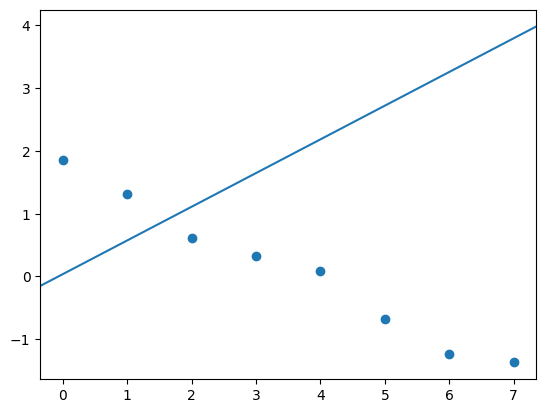

In [ ]:
regression_plot(x, y, m, b)

Podemos repetir los pasos 1 y 2 para confirmar que el coste ha disminuido:

In [ ]:
C = mse(regression(x, m, b), y)
C

tensor(8.5722, grad_fn=<DivBackward0>)

Pon los 4 pasos en un bucle para minimizar iterativamente el coste hacia cero:

In [ ]:
epochs = 1000
for epoch in range(epochs):

    optimizer.zero_grad() # Reinicial gradiente a zero; si no, se acumularía

    yhat = regression(x, m, b) # Paso 1
    C = mse(yhat, y) # Paso 2

    C.backward() # Paso 3
    optimizer.step() # Paso 4

    print('Epoch {}, coste {}, m grad {}, b grad {}'.format(epoch, '%.3g' % C.item(), '%.3g' % m.grad.item(), '%.3g' % b.grad.item()))

Epoch 0, coste 8.57, m grad 23.2, b grad 3.6
Epoch 1, coste 4.08, m grad 14.8, b grad 1.91
Epoch 2, coste 2.25, m grad 9.49, b grad 0.831
Epoch 3, coste 1.51, m grad 6.11, b grad 0.15
Epoch 4, coste 1.2, m grad 3.96, b grad -0.28
Epoch 5, coste 1.07, m grad 2.59, b grad -0.552
Epoch 6, coste 1.01, m grad 1.72, b grad -0.723
Epoch 7, coste 0.981, m grad 1.17, b grad -0.829
Epoch 8, coste 0.962, m grad 0.82, b grad -0.894
Epoch 9, coste 0.948, m grad 0.595, b grad -0.934
Epoch 10, coste 0.936, m grad 0.452, b grad -0.957
Epoch 11, coste 0.925, m grad 0.361, b grad -0.969
Epoch 12, coste 0.915, m grad 0.302, b grad -0.975
Epoch 13, coste 0.904, m grad 0.265, b grad -0.977
Epoch 14, coste 0.894, m grad 0.241, b grad -0.976
Epoch 15, coste 0.884, m grad 0.225, b grad -0.973
Epoch 16, coste 0.874, m grad 0.214, b grad -0.969
Epoch 17, coste 0.864, m grad 0.207, b grad -0.965
Epoch 18, coste 0.854, m grad 0.202, b grad -0.96
Epoch 19, coste 0.845, m grad 0.199, b grad -0.955
Epoch 20, coste 0

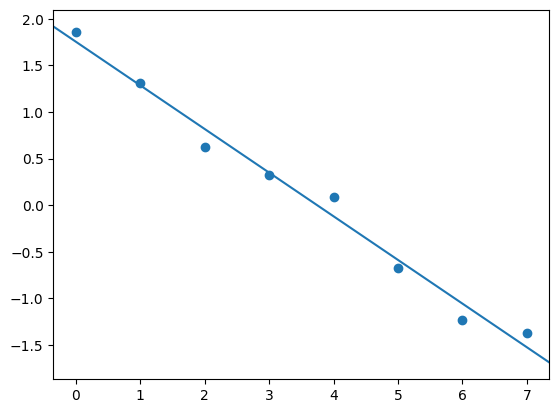

In [ ]:
regression_plot(x, y, m, b)

In [ ]:
m.item()

-0.4681258499622345

In [ ]:
b.item()

1.7542961835861206

**N.B.**: El modelo no se aproxima perfectamente a la pendiente (-0,5) y a la intersección $y$ (2,0) utilizadas para simular los resultados $y$ en la parte superior de este cuaderno. Esto refleja la imperfección de la muestra de ocho puntos de datos debido a la adición de ruido aleatorio durante el paso de simulación. En el mundo real, la mejor solución sería muestrear puntos de datos adicionales: Cuantos más datos muestreemos, más precisas serán nuestras estimaciones de los verdaderos parámetros subyacentes.

In [13]:
#Ejercicio
#Calcula la derivada de y = x^2+2x+2 en x=2
import torch
import numpy as np
x = torch.Tensor([2]).requires_grad_()
y = x**2+2*x+2
y.backward()
print("La de rivada de y en x=2 es: ",np.array(x.grad[0].int()))

La de rivada de y en x=2 es:  6
